In [19]:
import pandas as pd
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import plotly.graph_objs as go

In [20]:
# Set the relative path to the data directory
data_dir = os.path.join('..', 'Stock')

# Function to get all CSV files
def get_csv_files(directory):
    return glob.glob(os.path.join(directory, '*.csv'))

# List all CSV files
csv_files = get_csv_files(data_dir)
print("CSV files:", csv_files)

# load a specific CSV file by name
def load_csv_file(filename, directory):
    file_path = os.path.join(directory, filename)
    return pd.read_csv(file_path)

CSV files: ['..\\Stock\\AAPL.csv', '..\\Stock\\AMZN.csv', '..\\Stock\\BA.csv', '..\\Stock\\GOOG.csv', '..\\Stock\\IBM.csv', '..\\Stock\\merged_stock_data.csv', '..\\Stock\\MGM.csv', '..\\Stock\\SP500.csv', '..\\Stock\\T.csv', '..\\Stock\\TSLA.csv']


In [21]:
# Load a specific CSV file
csv_file_to_load = 'AAPL.csv'
df = pd.read_csv(csv_files[0])
df

,Date,Open,High,Low,Close,Volume
0,01-02-2019,38.72,39.71,38.56,39.48,"14,81,58,952"
1,01-03-2019,36.00,36.43,35.50,35.55,"36,52,48,812"
2,01-04-2019,36.13,37.14,35.95,37.07,"23,44,28,280"
3,01-07-2019,37.18,37.21,36.48,36.98,"21,91,11,048"
4,01-08-2019,37.39,37.96,37.13,37.69,"16,41,01,248"
...,...,...,...,...,...,...
1349,05/14/2024,187.51,188.30,186.29,187.43,"5,23,93,621"
1350,05/15/2024,187.91,190.65,187.37,189.72,"7,03,99,992"
1351,05/16/2024,190.47,191.10,189.66,189.84,"5,28,45,230"
1352,05/17/2024,189.51,190.81,189.18,189.87,"4,12,82,930"


In [26]:
def reformat_date(date):
    return date.replace('-', '/')

# Apply the function to the first column (dates)
df['Date'] = df['Date'].apply(reformat_date)
df

,Date,Open,High,Low,Close,Volume
0,01/02/2019,38.72,39.71,38.56,39.48,"14,81,58,952"
1,01/03/2019,36.00,36.43,35.50,35.55,"36,52,48,812"
2,01/04/2019,36.13,37.14,35.95,37.07,"23,44,28,280"
3,01/07/2019,37.18,37.21,36.48,36.98,"21,91,11,048"
4,01/08/2019,37.39,37.96,37.13,37.69,"16,41,01,248"
...,...,...,...,...,...,...
1349,05/14/2024,187.51,188.30,186.29,187.43,"5,23,93,621"
1350,05/15/2024,187.91,190.65,187.37,189.72,"7,03,99,992"
1351,05/16/2024,190.47,191.10,189.66,189.84,"5,28,45,230"
1352,05/17/2024,189.51,190.81,189.18,189.87,"4,12,82,930"


In [27]:
df['Date'] = pd.to_datetime(df['Date'])
df

,Date,Open,High,Low,Close,Volume
0,2019-01-02,38.72,39.71,38.56,39.48,"14,81,58,952"
1,2019-01-03,36.00,36.43,35.50,35.55,"36,52,48,812"
2,2019-01-04,36.13,37.14,35.95,37.07,"23,44,28,280"
3,2019-01-07,37.18,37.21,36.48,36.98,"21,91,11,048"
4,2019-01-08,37.39,37.96,37.13,37.69,"16,41,01,248"
...,...,...,...,...,...,...
1349,2024-05-14,187.51,188.30,186.29,187.43,"5,23,93,621"
1350,2024-05-15,187.91,190.65,187.37,189.72,"7,03,99,992"
1351,2024-05-16,190.47,191.10,189.66,189.84,"5,28,45,230"
1352,2024-05-17,189.51,190.81,189.18,189.87,"4,12,82,930"


In [23]:
def change_format(date):
    # Split the date by '-' and rearrange it as needed
    parts = date.split('-')
    return f'{parts[2]}-{parts[1]}-{parts[0]}'

In [11]:
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=50, hidden_size=50, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(50, 25)
        self.fc2 = nn.Linear(25, 1)
        
    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out = out[:, -1, :]  # Get the last output of the sequence
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [13]:
csv_names = ["AAPL", "AMZN", "BA", "GOOG", "IBM", "MGM", "SP500", "T", "TSLA"]
print(csv_names)

['AAPL', 'AMZN', 'BA', 'GOOG', 'IBM', 'MGM', 'SP500', 'T', 'TSLA']


In [37]:
for file in range(len(csv_files)):
    print(f'Training the model for stock {csv_names[file]}')
    print('----------------------------------------------------')
    
    df = pd.read_csv(csv_files[file])
    df['Date'] = df['Date'].apply(reformat_date)
    
    # Parse the Date column to datetime
    df['Date'] = pd.to_datetime(df['Date'])

    # Set the Date column as the index
    df.set_index('Date', inplace=True)

    # Sort the data by date
    df.sort_index(inplace=True)

       # Convert 'Close' column to numpy.float64 explicitly
    df['Close'] = df['Close'].str.replace(',', '').astype(np.float64)

    # Selecting the feature and target columns
    data = df[['Close']].values
    # Selecting the feature and target columns
    # data = df[['Close']].values

    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    train_size = int(len(scaled_data) * 0.8)
    train_data = scaled_data[:train_size]
    test_data = scaled_data[train_size:]

    def create_dataset(dataset, time_step=1):
        X, Y = [], []
        for i in range(len(dataset) - time_step - 1):
            a = dataset[i:(i + time_step), 0]
            X.append(a)
            Y.append(dataset[i + time_step, 0])
        return np.array(X), np.array(Y)

    time_step = 60
    X_train, y_train = create_dataset(train_data, time_step)
    X_test, y_test = create_dataset(test_data, time_step)

    # Convert to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(2)
    y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(2)
    y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

    model = LSTMModel()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 500
    batch_size = 64

    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True
    )

    for epoch in range(num_epochs):
        for inputs, targets in train_loader:
            model.train()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

    # Save the model
    torch.save(model.state_dict(), f"model_{csv_names[file]}.pth")

Training the model for stock SP500
----------------------------------------------------
Epoch 1/500, Loss: 0.08040400594472885
Epoch 2/500, Loss: 0.048219047486782074
Epoch 3/500, Loss: 0.022953998297452927
Epoch 4/500, Loss: 0.02666280046105385
Epoch 5/500, Loss: 0.019692422822117805
Epoch 6/500, Loss: 0.0048343404196202755
Epoch 7/500, Loss: 0.0025136517360806465
Epoch 8/500, Loss: 0.0032301549799740314
Epoch 9/500, Loss: 0.002867091214284301
Epoch 10/500, Loss: 0.00241358601488173
Epoch 11/500, Loss: 0.00242918380536139
Epoch 12/500, Loss: 0.0018574846908450127
Epoch 13/500, Loss: 0.0015120944008231163
Epoch 14/500, Loss: 0.0016609937883913517
Epoch 15/500, Loss: 0.0014514281647279859
Epoch 16/500, Loss: 0.001986461691558361
Epoch 17/500, Loss: 0.0013521094806492329
Epoch 18/500, Loss: 0.0012738608056679368
Epoch 19/500, Loss: 0.0015799712855368853
Epoch 20/500, Loss: 0.00151357043068856
Epoch 21/500, Loss: 0.0006979286554269493
Epoch 22/500, Loss: 0.000883164000697434
Epoch 23/500,

In [32]:
df = pd.read_csv(csv_files[0])
print(type(df['Close'][0]))


<class 'numpy.float64'>


In [41]:
import pandas as pd
import os

# List of CSV files and corresponding stock names
csv_files = ['..\\Stock\\AAPL.csv', '..\\Stock\\AMZN.csv', '..\\Stock\\BA.csv', '..\\Stock\\GOOG.csv', '..\\Stock\\IBM.csv', '..\\Stock\\MGM.csv', '..\\Stock\\SP500.csv', '..\\Stock\\T.csv', '..\\Stock\\TSLA.csv']
stock_names = ['AAPL', 'AMZN', 'BA', 'GOOG', 'IBM', 'MGM', 'SP500', 'T', 'TSLA']

# Initialize an empty DataFrame to store the merged data
merged_df = pd.DataFrame()

# Iterate over the CSV files and stock names
for file, stock in zip(csv_files, stock_names):
    # Load the CSV file
    df = pd.read_csv(file, parse_dates=['Date'], index_col='Date')
    
    # Rename the 'Close' column to the stock name
    df = df[['Close']].rename(columns={'Close': stock})
    
    # Merge the DataFrame with the merged_df on the 'Date' column
    if merged_df.empty:
        merged_df = df
    else:
        merged_df = merged_df.join(df, how='outer')

# Reset the index to make 'Date' a column
merged_df.reset_index(inplace=True)

# Save the merged DataFrame to a new CSV file
merged_df.to_csv('merged_stock_data.csv', index=False)

# Display the first few rows of the merged DataFrame
merged_df

,Date,AAPL,AMZN,BA,GOOG,IBM,MGM,SP500,T,TSLA
0,2019-01-02,39.48,76.96,323.81,52.29,110.04,25.19,"2,510.03",22.31,20.67
1,2019-01-03,35.55,75.01,310.90,50.80,107.85,24.70,"2,447.89",22.34,20.02
2,2019-01-04,37.07,78.77,327.08,53.54,112.06,25.77,"2,531.94",22.91,21.18
3,2019-01-07,36.98,81.48,328.11,53.42,112.85,26.51,"2,549.69",23.33,22.33
4,2019-01-08,37.69,82.83,340.53,53.81,114.46,27.21,"2,574.41",23.62,22.36
...,...,...,...,...,...,...,...,...,...,...
1350,2024-05-14,187.43,187.07,180.76,171.93,167.36,41.29,"5,246.68",17.30,177.55
1351,2024-05-15,189.72,185.99,176.99,173.88,168.26,41.55,"5,308.15",17.33,173.99
1352,2024-05-16,189.84,183.63,182.96,175.43,168.97,41.65,"5,297.10",17.30,174.84
1353,2024-05-17,189.87,184.70,184.95,177.29,169.03,41.03,"5,303.27",17.40,177.46


In [23]:
import pandas as pd
import os

# List of CSV files and corresponding stock names
csv_files = ['../Stock/AAPL.csv', '../Stock/AMZN.csv', '../Stock/BA.csv', '../Stock/GOOG.csv', '../Stock/IBM.csv', '../Stock/MGM.csv', '../Stock/SP500.csv', '../Stock/T.csv', '../Stock/TSLA.csv']
stock_names = ['AAPL', 'AMZN', 'BA', 'GOOG', 'IBM', 'MGM', 'SP500', 'T', 'TSLA']

# Initialize an empty DataFrame to store the merged data
merged_df = pd.DataFrame()

# Iterate over the CSV files and stock names
for file, stock in zip(csv_files, stock_names):
    # Load the CSV file
    df = pd.read_csv(file, parse_dates=['Date'], index_col='Date')
    print(df)
    # Rename the 'Close' column to the stock name
    df = df[['Close']].rename(columns={'Close': stock})
    
    # Merge the DataFrame with the merged_df on the 'Date' column
    if merged_df.empty:
        merged_df = df
    else:
        merged_df = merged_df.join(df, how='outer')
        # print(merged_df)

# Reset the index to make 'Date' a column
merged_df.reset_index(inplace=True)

# If there are commas in SP500 data, remove them and convert to float
if 'SP500' in merged_df.columns:
    merged_df['SP500'] = merged_df['SP500'].str.replace(',', '').astype(np.float64)

# Save the merged DataFrame to a new CSV file
# merged_df.to_csv('merged_stock_data.csv', index=False)

# Display the first few rows of the merged DataFrame
merged_df


              Open    High     Low   Close        Volume
Date                                                    
2019-01-02   38.72   39.71   38.56   39.48  14,81,58,952
2019-01-03   36.00   36.43   35.50   35.55  36,52,48,812
2019-01-04   36.13   37.14   35.95   37.07  23,44,28,280
2019-01-07   37.18   37.21   36.48   36.98  21,91,11,048
2019-01-08   37.39   37.96   37.13   37.69  16,41,01,248
...            ...     ...     ...     ...           ...
2024-05-14  187.51  188.30  186.29  187.43   5,23,93,621
2024-05-15  187.91  190.65  187.37  189.72   7,03,99,992
2024-05-16  190.47  191.10  189.66  189.84   5,28,45,230
2024-05-17  189.51  190.81  189.18  189.87   4,12,82,930
2024-05-20  189.33  191.92  189.01  191.04   4,43,61,281

[1354 rows x 5 columns]
              Open    High     Low   Close        Volume
Date                                                    
2019-01-02   73.26   77.67   73.05   76.96  15,96,62,078
2019-01-03   76.00   76.90   74.86   75.01  13,95,11,438
2019-0

,Date,AAPL,AMZN,BA,GOOG,IBM,MGM,SP500,T,TSLA
0,2019-01-02,39.48,76.96,323.81,52.29,110.04,25.19,2510.03,22.31,20.67
1,2019-01-03,35.55,75.01,310.90,50.80,107.85,24.70,2447.89,22.34,20.02
2,2019-01-04,37.07,78.77,327.08,53.54,112.06,25.77,2531.94,22.91,21.18
3,2019-01-07,36.98,81.48,328.11,53.42,112.85,26.51,2549.69,23.33,22.33
4,2019-01-08,37.69,82.83,340.53,53.81,114.46,27.21,2574.41,23.62,22.36
...,...,...,...,...,...,...,...,...,...,...
1350,2024-05-14,187.43,187.07,180.76,171.93,167.36,41.29,5246.68,17.30,177.55
1351,2024-05-15,189.72,185.99,176.99,173.88,168.26,41.55,5308.15,17.33,173.99
1352,2024-05-16,189.84,183.63,182.96,175.43,168.97,41.65,5297.10,17.30,174.84
1353,2024-05-17,189.87,184.70,184.95,177.29,169.03,41.03,5303.27,17.40,177.46


In [42]:
merged_df['SP500'] = merged_df['SP500'].str.replace(',', '').astype(np.float64)
merged_df.to_csv('merged_stock_data.csv', index=False)

In [5]:
df = pd.read_csv(csv_files[5])
df

,Date,AAPL,AMZN,BA,GOOG,IBM,MGM,SP500,T,TSLA
0,2019-01-02,39.48,76.96,323.81,52.29,110.04,25.19,2510.03,22.31,20.67
1,2019-01-03,35.55,75.01,310.90,50.80,107.85,24.70,2447.89,22.34,20.02
2,2019-01-04,37.07,78.77,327.08,53.54,112.06,25.77,2531.94,22.91,21.18
3,2019-01-07,36.98,81.48,328.11,53.42,112.85,26.51,2549.69,23.33,22.33
4,2019-01-08,37.69,82.83,340.53,53.81,114.46,27.21,2574.41,23.62,22.36
...,...,...,...,...,...,...,...,...,...,...
1350,2024-05-14,187.43,187.07,180.76,171.93,167.36,41.29,5246.68,17.30,177.55
1351,2024-05-15,189.72,185.99,176.99,173.88,168.26,41.55,5308.15,17.33,173.99
1352,2024-05-16,189.84,183.63,182.96,175.43,168.97,41.65,5297.10,17.30,174.84
1353,2024-05-17,189.87,184.70,184.95,177.29,169.03,41.03,5303.27,17.40,177.46


In [6]:
def normalize_the_price(df):
  """normalize the prices based on the initial price
  """
  historic_data = df.iloc[:,1:].copy()
  start = df.iloc[0,1:]

  return historic_data/start

In [7]:
df_norm = normalize_the_price(df)
df_norm.head()

,AAPL,AMZN,BA,GOOG,IBM,MGM,SP500,T,TSLA
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.900456,0.974662,0.960131,0.971505,0.980098,0.980548,0.975243,1.001345,0.968553
2,0.938956,1.023519,1.010099,1.023905,1.018357,1.023025,1.008729,1.026894,1.024673
3,0.936677,1.058732,1.013279,1.02161,1.025536,1.052402,1.015801,1.045719,1.08031
4,0.954661,1.076273,1.051635,1.029069,1.040167,1.080191,1.025649,1.058718,1.081761


In [8]:
# These are our random weigths
Weights = np.random.random(len(df.columns[1:]))
# These Weights should sum to one
Weights = Weights/sum(Weights)
Weights

array([0.02192478, 0.01334295, 0.2031096 , 0.12015291, 0.09828903,
       0.11526313, 0.01752246, 0.23790997, 0.17248518])

In [9]:
# Historic data -- normalized based on initial price
X = df_norm.values
print('Shape of historic data',X.shape)

Shape of historic data (1355, 9)


In [10]:
portfolio_daily_worth = X@Weights

print('Shape of matrix multiplication',portfolio_daily_worth.shape)

Shape of matrix multiplication (1355,)


In [11]:
# Enter invested amount in $
invested_amount = 1000000

In [12]:
df['portfolio daily worth in $'] = portfolio_daily_worth*invested_amount
df.head()

,Date,AAPL,AMZN,BA,GOOG,IBM,MGM,SP500,T,TSLA,portfolio daily worth in $
0,2019-01-02,39.48,76.96,323.81,52.29,110.04,25.19,2510.03,22.31,20.67,1000000.0
1,2019-01-03,35.55,75.01,310.90,50.80,107.85,24.70,2447.89,22.34,20.02,976221.703031
2,2019-01-04,37.07,78.77,327.08,53.54,112.06,25.77,2531.94,22.91,21.18,1019164.094682
3,2019-01-07,36.98,81.48,328.11,53.42,112.85,26.51,2549.69,23.33,22.33,1038245.118422
4,2019-01-08,37.69,82.83,340.53,53.81,114.46,27.21,2574.41,23.62,22.36,1055716.567163


In [13]:
# lets graph the protfolio daily worth 
import plotly.express as px

fig = px.line(x='Date', y='portfolio daily worth in $', data_frame=df, title = 'portfolio daily worth in $')
fig.show()

In [14]:
def get_stock_daily_return(df):
  h = df.copy()
  h_shifted = h.shift().fillna(0)
  # Calculate the percentage of change from the previous day
  r = ((h - h_shifted)/h_shifted)*100
  r.iloc[0] = 0
  return r.astype(np.float64)

In [15]:
X = df['Date']
X

0       2019-01-02
1       2019-01-03
2       2019-01-04
3       2019-01-07
4       2019-01-08
           ...    
1350    2024-05-14
1351    2024-05-15
1352    2024-05-16
1353    2024-05-17
1354    2024-05-20
Name: Date, Length: 1355, dtype: object

In [16]:
stocks_daily_return = get_stock_daily_return(df_norm)
stocks_daily_return

,AAPL,AMZN,BA,GOOG,IBM,MGM,SP500,T,TSLA
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-9.954407,-2.533784,-3.986906,-2.849493,-1.990185,-1.945216,-2.475668,0.134469,-3.144654
2,4.275668,5.012665,5.204246,5.393701,3.903570,4.331984,3.433569,2.551477,5.794206
3,-0.242784,3.440396,0.314908,-0.224131,0.704979,2.871556,0.701043,1.833261,5.429651
4,1.919957,1.656848,3.785316,0.730064,1.426673,2.640513,0.969530,1.243035,0.134348
...,...,...,...,...,...,...,...,...,...
1350,0.617350,0.267996,1.300157,0.602692,-0.119360,0.879550,0.483776,0.231750,3.292804
1351,1.221789,-0.577324,-2.085638,1.134183,0.537763,0.629692,1.171598,0.173410,-2.005069
1352,0.063251,-1.268885,3.373072,0.891419,0.421966,0.240674,-0.208170,-0.173110,0.488534
1353,0.015803,0.582693,1.087669,1.060252,0.035509,-1.488595,0.116479,0.578035,1.498513


In [77]:
# Replace inf and -inf with NaN
stocks_daily_return.replace([np.inf, -np.inf], np.nan, inplace=True)

# Replace NaN with the mean of the column
stocks_daily_return.fillna(stocks_daily_return.mean(), inplace=True)

In [78]:
df_plot = pd.concat([X, stocks_daily_return], axis=1)
df_plot

,Date,AAPL,AMZN,BA,GOOG,IBM,MGM,SP500,T,TSLA
0,2019-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2019-01-03,-9.954407,-2.533784,-3.986906,-2.849493,-1.990185,-1.945216,-2.475668,0.134469,-3.144654
2,2019-01-04,4.275668,5.012665,5.204246,5.393701,3.903570,4.331984,3.433569,2.551477,5.794206
3,2019-01-07,-0.242784,3.440396,0.314908,-0.224131,0.704979,2.871556,0.701043,1.833261,5.429651
4,2019-01-08,1.919957,1.656848,3.785316,0.730064,1.426673,2.640513,0.969530,1.243035,0.134348
...,...,...,...,...,...,...,...,...,...,...
1350,2024-05-14,0.617350,0.267996,1.300157,0.602692,-0.119360,0.879550,0.483776,0.231750,3.292804
1351,2024-05-15,1.221789,-0.577324,-2.085638,1.134183,0.537763,0.629692,1.171598,0.173410,-2.005069
1352,2024-05-16,0.063251,-1.268885,3.373072,0.891419,0.421966,0.240674,-0.208170,-0.173110,0.488534
1353,2024-05-17,0.015803,0.582693,1.087669,1.060252,0.035509,-1.488595,0.116479,0.578035,1.498513


In [84]:
# Define the list of stocks
stocks = ['AAPL', 'AMZN', 'BA', 'GOOG', 'IBM', 'MGM', 'SP500', 'T', 'TSLA']
# stocks = ['AAPL']

# Create a plot for each stock
for stock in stocks:
    fig = px.line(df_plot, x='Date', y=stock, title=f'{stock} Returns Over Time')
    fig.show()

In [89]:
stocks = ['AAPL', 'AMZN', 'BA', 'GOOG', 'IBM', 'MGM', 'T', 'TSLA']

In [90]:
# Market
market = stocks_daily_return['SP500'].to_list()
print(market)
# Market return
# average daily rate of return for S&P500
print('Mean of market daily return',sum(market)/len(market))


[0.0, -2.475667621502542, 3.4335693188828036, 0.7010434686445963, 0.9695296290921451, 0.40980263439002723, 0.45184451596929465, -0.014634296629475492, -0.5257562801876537, 1.0721711756711212, 0.222196682373657, 0.7591452926111494, 1.3183052853609318, -1.4157284018107503, 0.22028941471379732, 0.13756774169099953, 0.8488720182566066, -0.7846860505261349, -0.14562096941958327, 1.5549242424242542, 0.8597377892989462, 0.08986354054955271, 0.6776204217207863, 0.47084815055397883, -0.22244950140628056, -0.9357119061652298, 0.06762624489569383, 0.07090417596052702, 1.2890250202967013, 0.30239768574686166, -0.2651623847179313, 1.087870985129639, 0.14987750396310745, 0.17771318387198815, -0.35264121808453186, 0.6411088047050614, 0.12317960947768976, -0.07903837831845285, -0.054404237803791174, -0.2825546666284755, 0.6895338105003179, -0.388060020901037, -0.1131476899609956, -0.652411592852169, -0.8125710368218729, -0.21317385309919012, 1.466604935346162, 0.2953328782380502, 0.6949618845646789, -

In [92]:
# Let's calculate the annualized rate of return for S&P500 
# Note that out of 365 days/year, stock exchanges are closed for 104 days during weekend days (Saturday and Sunday) 
# Apart from the weekends, there are other holidays.

rm = stocks_daily_return['SP500'].mean() * 252

print('Annualized rate of return for S&P500 ',rm)

Annualized rate of return for S&P500  16.146003393451142


In [93]:
# Current yield on a U.S. 10-year treasury is 2.5%
rf = 0.025

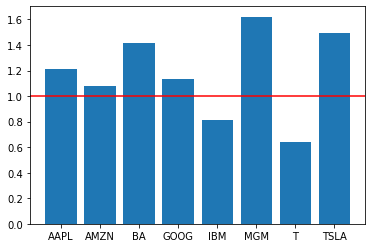

In [94]:
beta = {}
for stock in stocks:
  security = stocks_daily_return[stock]
  market = stocks_daily_return['SP500']
  slope, y_intercept = np.polyfit(market, security, deg=1) 
  beta[stock]=slope

plt.bar(beta.keys(),beta.values());
plt.axhline(y=1.0, c='r');

In [95]:
expected_return = {}

for stock in stocks:
   er = rf+(beta[stock]*(rm-rf))
   expected_return[stock] = er

expected_return

{'AAPL': 19.543488639825753,
 'AMZN': 17.406803626186157,
 'BA': 22.883175492234685,
 'GOOG': 18.318932065732895,
 'IBM': 13.150726696067293,
 'MGM': 26.168871989166114,
 'T': 10.39897965406372,
 'TSLA': 24.16427598932839}

Text(0.5, 1.0, 'Expected Return')

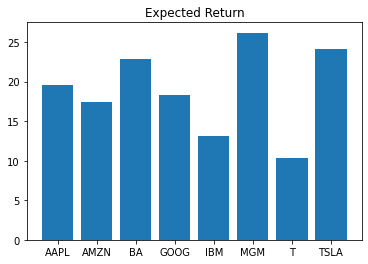

In [96]:
plt.bar(expected_return.keys(),expected_return.values())
plt.title('Expected Return')

In [97]:
# Lets assign equal weights to all of them
weight = 1/len(stocks)
weights = weight*np.ones(len(stocks))

print(weights)

[0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]


In [98]:
# Expected return of the portfolio
expected_return_of_the_portfolio = np.dot(np.array(list(expected_return.values())), weights)
print('Expected return of the portfolio : ',expected_return_of_the_portfolio)

Expected return of the portfolio :  19.00440676907563
